# Angle embedding (simulator)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using amplitude embedding (non-conventional domain)
* measure qubits on simulator --> expected outcomes (back to conventional domain)
* apply 2D IFT --> fidelity computation

Amplitude embedding:

* from https://docs.pennylane.ai/en/stable/code/api/pennylane.AmplitudeEmbedding.html
* literature: https://hillside.net/plop/2020/papers/weigold.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import pennylane as qml
from pennylane import numpy as pnp

## 1) Generating an artificial image of the sky (frequency domain)

In [2]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)
n = 4 #20
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(3, 11)
radius = 1 #np.random.randint(1, 3)

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 3.0727668e-03+2.4729563e-02j  9.7829914e-03+7.2282455e-03j
  -1.5235436e-02+4.7353577e-04j -3.5854240e-03-3.8214719e-03j]
 [ 9.5737269e-03-1.1221851e-03j  2.0996485e+01+3.5195980e+01j
   7.5435471e+01+5.1665092e+01j  1.1194140e-02+1.8410742e-02j]
 [ 8.0911247e+01+7.6932320e+01j  5.3387798e+01+9.0824654e+01j
  -1.5735783e-02+2.2172980e-02j -7.8497957e-03+1.7782558e-03j]
 [ 3.1245071e-03+1.9622833e-02j -2.0798245e-02+4.6899463e-03j
   2.6236109e-02-2.8212091e-03j -1.5718659e-02+1.7959690e-02j]]


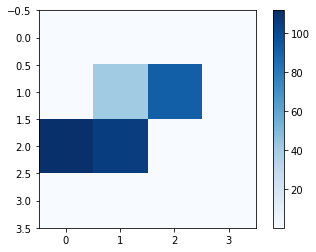

In [3]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [4]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 230.71506 +254.72734j    131.4945   -49.098595j
    82.00044   +2.5935886j -120.501945 +99.67986j  ]
 [ -47.442516-264.2122j    -244.39954  +16.708336j
   -11.078496 -40.477753j   -20.795137 -19.674545j ]
 [  37.82393  +80.89172j    212.06392  +96.14937j
   -27.00604  -30.293875j   100.72467 +161.00697j  ]
 [-221.12033  -71.292435j   -99.04147  -63.715557j
   -43.98935  +68.26522j     40.60144 -240.8618j   ]]


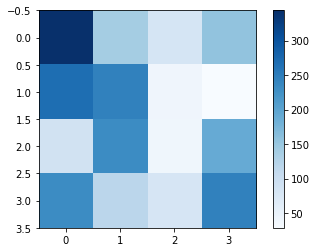

In [5]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [6]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 5.3714325e-13
Imaginaries MSE: 5.2831036e-13


## 3) Data encoding: amplitude embedding (non-conventional domain)

In [15]:
np.zeros(2**32)

MemoryError: Unable to allocate 32.0 GiB for an array with shape (4294967296,) and data type float64

In [13]:
# Amplitude embedding encodes a normalized 2^n-dimensional feature vector into the state of n qubits
# --> uses log2(n) qubits for n classical data
from pennylane.templates.embeddings import AngleEmbedding

n = visibilities.shape[0]*visibilities.shape[1]
data = visibilities.flatten()

data_real = []
data_imag = []
for i in range(0, len(data)):
    data_real.append(data[i].real)
    data_imag.append(data[i].imag)
datas = data_real + data_imag
print(datas)
wires = range(len(datas)) # set the number of qubits (no padding needed if outputs an integer=integer.0)
ang_dev = qml.device('default.qubit', wires)

# encoding
@qml.qnode(ang_dev)
def ang_encoding(data):
    AngleEmbedding(features=data, wires=wires, rotation='Z')
    return qml.state

readout = ang_encoding(datas).astype('complex64')
#qml.draw_mpl(ang_encoding)(datas);
#readout = np.array(readout).reshape(sky_image.shape[0], sky_image.shape[1])
print(readout)

[230.71506, 131.4945, 82.00044, -120.501945, -47.442516, -244.39954, -11.078496, -20.795137, 37.82393, 212.06392, -27.00604, 100.72467, -221.12033, -99.04147, -43.98935, 40.60144, 254.72734, -49.098595, 2.5935886, 99.67986, -264.2122, 16.708336, -40.477753, -19.674545, 80.89172, 96.14937, -30.293875, 161.00697, -71.292435, -63.715557, 68.26522, -240.8618]


MemoryError: Unable to allocate 64.0 GiB for an array with shape (4294967296,) and data type complex128

## 4) Applying 2D IFT (fidelity test)

In [ ]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Blues')
axs[1].imshow(modulus2, cmap='Blues')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')